In [ ]:
!pip install opendatasets

In [ ]:
!pip install pandas

In [1]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
%matplotlib inline
from scipy import ndimage
from skimage.measure import regionprops
from skimage import io
from skimage.filters import threshold_otsu   # For finding the threshold for grayscale to binary conversion
import tensorflow as tf
import pandas as pd
from pandas.plotting import parallel_coordinates
import numpy as np
from time import time
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import keras
from tensorflow.python.framework import ops
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(tf.__version__)

2.15.0


In [ ]:
genuine_image_paths = "/content/drive/My Drive/Final Year Proj/Colab Notebooks/Real Signs"
forged_image_paths = "/content/drive/My Drive/Final Year Proj/Colab Notebooks/Forged Signs"

In [ ]:
#PREPROCESSING
def rgbgrey(img):
    # Converts rgb to grayscale
    greyimg = np.zeros((img.shape[0], img.shape[1]))  #create an empty grayscale image (greyimg) with the same dimensions as the input image
    for row in range(len(img)):
        for col in range(len(img[row])):
            greyimg[row][col] = np.average(img[row][col]) #For each pixel in the image, calculate the average value of the RGB channels (grayscale value for that pixel)
    return greyimg

In [ ]:
def greybin(img):
    # Converts grayscale to binary
    blur_radius = 0.8
    img = ndimage.gaussian_filter(img, blur_radius)  # to remove small components or noise
#     img = ndimage.binary_erosion(img).astype(img.dtype)
    thres = threshold_otsu(img)
    binimg = img > thres
    binimg = np.logical_not(binimg)
    return binimg

In [ ]:
def preproc(path, img=None, display=True):   #use seaborn plot
    if img is None:
        img = mpimg.imread(path)
#    if display:
#        plt.imshow(img)
#        plt.show()
#        plt.close()
    grey = rgbgrey(img) #rgb to grey
#    if display:
#        plt.imshow(grey, cmap = matplotlib.cm.Greys_r)
#        plt.show()
#        plt.close()
    binimg = greybin(grey) #grey to binary
    if display:
        plt.imshow(binimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
        plt.close()
    r, c = np.where(binimg==1)
    # Now we will make a bounding box with the boundary as the position of pixels on extreme.
    # Thus we will get a cropped image with only the signature part.
    signimg = binimg[r.min(): r.max(), c.min(): c.max()]
    if display:
        plt.imshow(signimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
        plt.close()
    return signimg

Feature Extraction

In [ ]:
def Ratio(img):
    a = 0
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                a = a+1
    total = img.shape[0] * img.shape[1]
    return a/total

In [ ]:
def Centroid(img):
    numOfWhites = 0
    a = np.array([0,0])
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                b = np.array([row,col])
                a = np.add(a,b)
                numOfWhites += 1
    rowcols = np.array([img.shape[0], img.shape[1]])
    centroid = a/numOfWhites
    centroid = centroid/rowcols
    return centroid[0], centroid[1]

In [ ]:
def EccentricitySolidity(img):
    r = regionprops(img.astype("int8"))
    return r[0].eccentricity, r[0].solidity

In [ ]:
def SkewKurtosis(img):
    h,w = img.shape
    x = range(w)  # cols value
    y = range(h)  # rows value
    #calculate projections along the x and y axes
    xp = np.sum(img,axis=0)
    yp = np.sum(img,axis=1)
    #centroid
    cx = np.sum(x*xp)/np.sum(xp)
    cy = np.sum(y*yp)/np.sum(yp)
    #standard deviation
    x2 = (x-cx)**2
    y2 = (y-cy)**2
    sx = np.sqrt(np.sum(x2*xp)/np.sum(img))
    sy = np.sqrt(np.sum(y2*yp)/np.sum(img))

    #skewness
    x3 = (x-cx)**3
    y3 = (y-cy)**3
    skewx = np.sum(xp*x3)/(np.sum(img) * sx**3)
    skewy = np.sum(yp*y3)/(np.sum(img) * sy**3)

    #Kurtosis
    x4 = (x-cx)**4
    y4 = (y-cy)**4
    # 3 is subtracted to calculate relative to the normal distribution
    kurtx = np.sum(xp*x4)/(np.sum(img) * sx**4) - 3
    kurty = np.sum(yp*y4)/(np.sum(img) * sy**4) - 3

    return (skewx , skewy), (kurtx, kurty)

In [ ]:
def getFeatures(path, img=None, display=True):
    if img is None:
        img = mpimg.imread(path)
    img = preproc(path, display=display)
    ratio = Ratio(img)
    centroid = Centroid(img)
    eccentricity, solidity = EccentricitySolidity(img)
    skewness, kurtosis = SkewKurtosis(img)
    retVal = (ratio, centroid, eccentricity, solidity, skewness, kurtosis)
    return retVal

In [ ]:
def getCSVFeatures(path, img=None, display=True):
    if img is None:
        img = mpimg.imread(path)
    temp = getFeatures(path, display=display)
    features = (temp[0], temp[1][0], temp[1][1], temp[2], temp[3], temp[4][0], temp[4][1], temp[5][0], temp[5][1])
    return features

### Saving Features

In [ ]:
def makeCSV():
    if not(os.path.exists('/content/drive/My Drive/Final Year Proj/Colab Notebooks/Features')):
        os.mkdir('/content/drive/My Drive/Final Year Proj/Colab Notebooks/Features')
        print('New folder "Features" created')
    if not(os.path.exists('/content/drive/My Drive/Final Year Proj/Colab Notebooks/Features/Training')):
        os.mkdir('/content/drive/My Drive/Final Year Proj/Colab Notebooks/Features/Training')
        print('New folder "Features/Training" created')
    if not(os.path.exists('/content/drive/My Drive/Final Year Proj/Colab Notebooks/Features/Testing')):
        os.mkdir('/content/drive/My Drive/Final Year Proj/Colab Notebooks/Features/Testing')
        print('New folder "Features/Testing" created')
    # genuine signatures path
    gpath = genuine_image_paths
    # forged signatures path
    fpath = forged_image_paths
    for person in range(1,55):
        per = (str(person))[-3:]
        print('Saving features for person id-',per)

        with open('/content/drive/My Drive/Final Year Proj/Colab Notebooks/Features/Training/training_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            #Training Testing spilt - 60/40
            #14 images training - 10 images testing

            # Training set
            for i in range(1,14):
                source = os.path.join(gpath, 'original_'+per+'_'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',1\n')
            for i in range(1,14):
                source = os.path.join(fpath, 'forgeries_'+per+'_'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',0\n')

        with open('/content/drive/My Drive/Final Year Proj/Colab Notebooks/Features/Testing/testing_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Testing set
            for i in range(14, 24):
                source = os.path.join(gpath, 'original_'+per+'_'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',1\n')
            for i in range(14,24):
                source = os.path.join(fpath, 'forgeries_'+per+'_'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',0\n')

Saving features for person id- 1


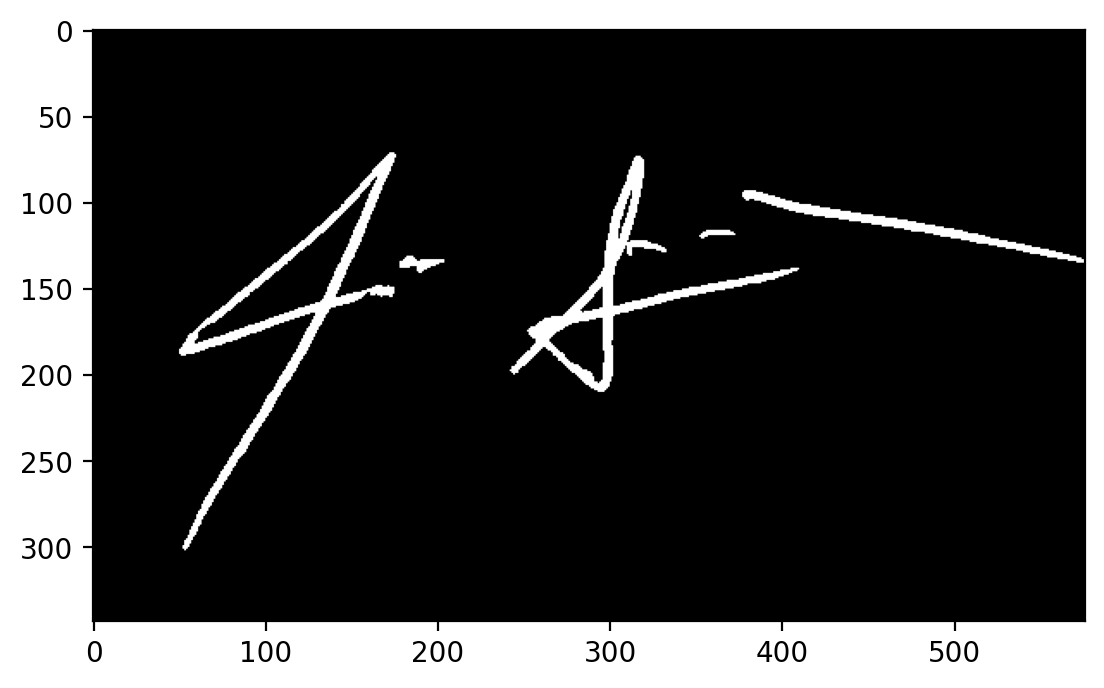

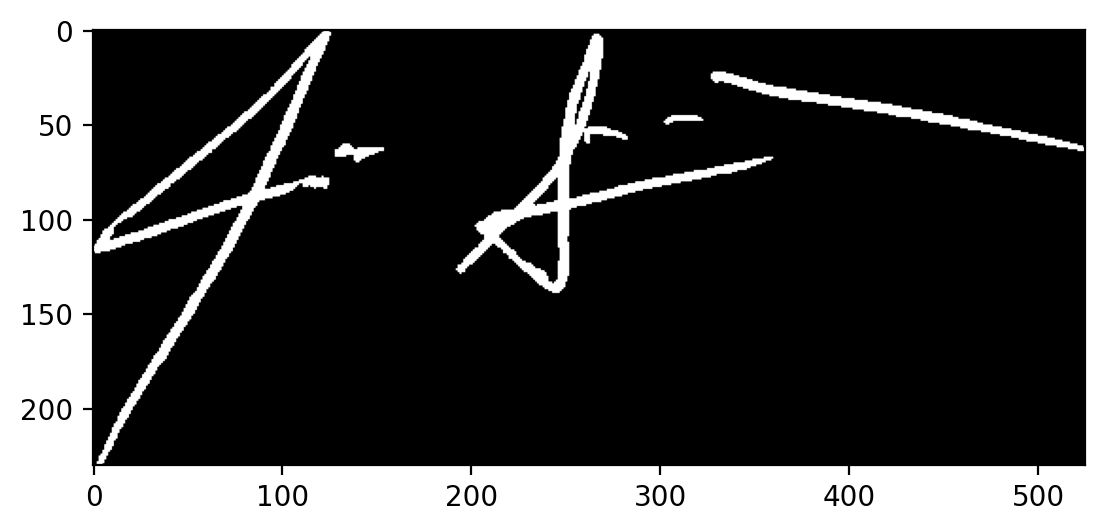

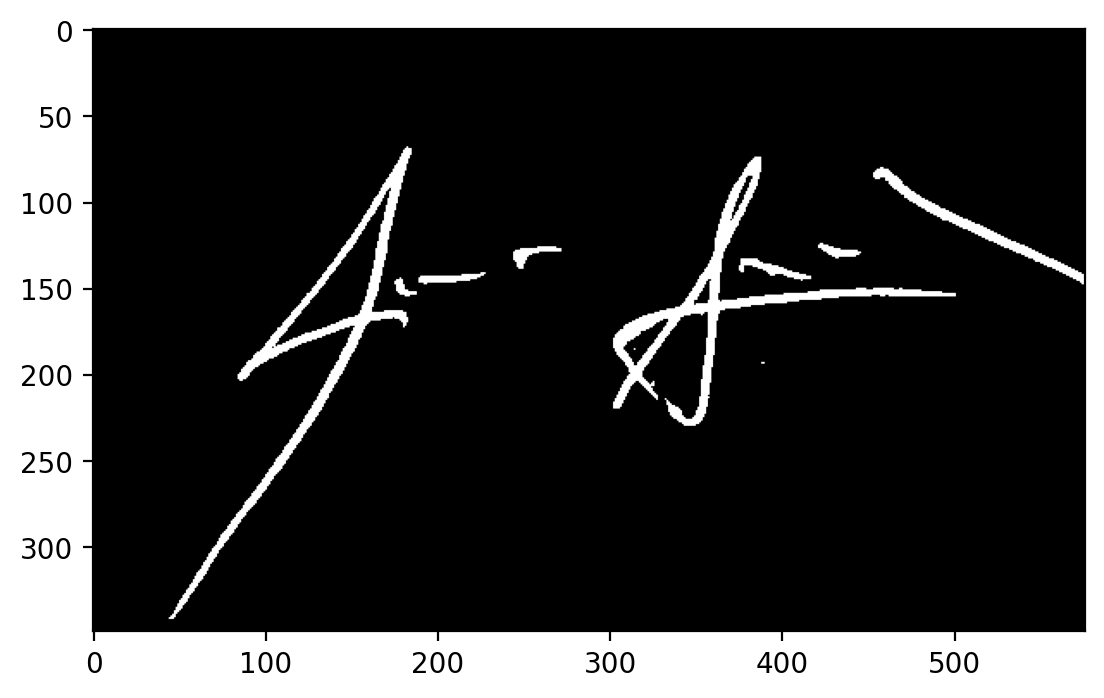

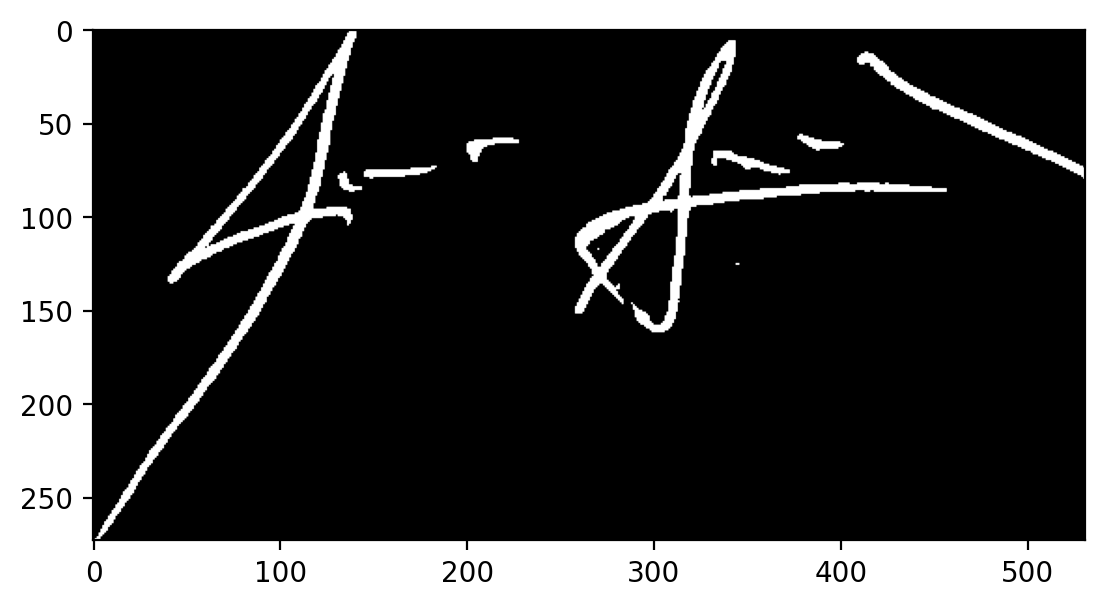

KeyboardInterrupt: 

In [ ]:
makeCSV()

In [ ]:
def testing(path):
    feature = getCSVFeatures(path)
    if not(os.path.exists('/content/drive/My Drive/Final Year Proj/Colab Notebooks/TestFeatures')):
        os.mkdir('/content/drive/My Drive/Final Year Proj/Colab Notebooks/TestFeatures')
    with open('/content/drive/My Drive/Final Year Proj/Colab Notebooks/TestFeatures/testcsv.csv', 'w') as handle:
        handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y\n')
        handle.write(','.join(map(str, feature))+'\n')

In [ ]:
def plot (path):
    df = pd.read_csv(path)

    # Convert Values to Float
    for column in df.columns:
        try:
          df[column] = df[column].astype(float)
        except ValueError:
          print("Cannot convert values in column '{column}' to float.")

    # Save the DataFrame to CSV
    df.to_csv('output_file.csv', index=False)

    # Create a Correlation Matrix
    correlation_matrix = df.corr()

    # Plot the Correlation Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()

    # Create Boxplots
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='output', y='ratio', data=df)
    plt.title('Boxplot of Ratio by Output Column')
    plt.show()

    # Repeat the above step for other variables as well
    sns.boxplot(x='output', y='cent_y', data=df)
    sns.boxplot(x='output', y='cent_x', data=df)
    sns.boxplot(x='output', y='eccentricity', data=df)
    sns.boxplot(x='output', y='solidity', data=df)
    sns.boxplot(x='output', y='skew_x', data=df)
    sns.boxplot(x='output', y='skew_y', data=df)
    sns.boxplot(x='output', y='kurt_x', data=df)
    sns.boxplot(x='output', y='kurt_y', data=df)

    # Show all the plots
    plt.show()

selected_columns = ['ratio', 'cent_y', 'cent_x', 'eccentricity', 'solidity', 'skew_x', 'skew_y', 'kurt_x', 'kurt_y']
    df_selected = df[selected_columns]

    # Normalize the continuous features (optional but recommended)
    df_selected.iloc[:, :-1] = (df_selected.iloc[:, :-1] - df_selected.iloc[:, :-1].min()) / (df_selected.iloc[:, :-1].max() - df_selected.iloc[:, :-1].min())

    # Create the parallel coordinates plot
    plt.figure(figsize=(10, 6))
    parallel_coordinates(df_selected, 'output', colormap='coolwarm')
    plt.title("Parallel Coordinates Plot: Features vs. Signature Real/Forged")
    plt.xlabel("Features")
    plt.ylabel("Normalized Values")
    plt.legend(title="Signature Real/Forged", loc='upper right')
    plt.show()


Enter person's id : 10
Enter path of signature image : /content/drive/My Drive/Final Year Proj/Colab Notebooks/Forged Signs/forgeries_10_15.png


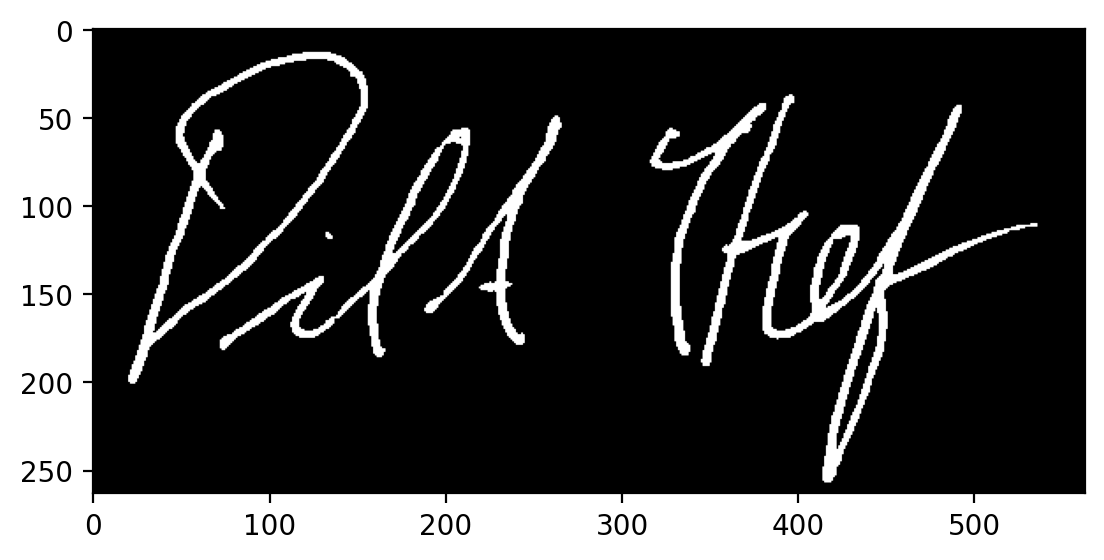

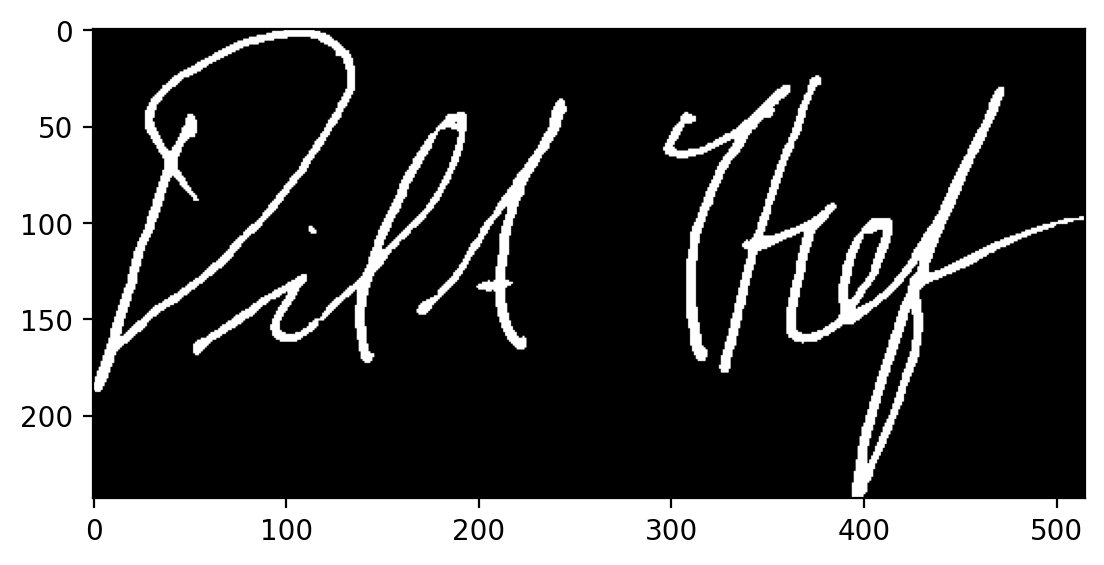

Cannot convert values in column '{column}' to float.


ValueError: could not convert string to float: '\x1a'

In [ ]:
n_input = 9
train_person_id = input("Enter person's id : ")
test_image_path = input("Enter path of signature image : ")
train_path = '/content/drive/My Drive/Final Year Proj/Colab Notebooks/Features/Training/training_'+train_person_id+'.csv'
testing(test_image_path)
test_path = '/content/drive/My Drive/Final Year Proj/Colab Notebooks/TestFeatures/testcsv.csv'

def readCSV(train_path, test_path, type2=False):

    # Reading train data
    df = pd.read_csv(train_path, usecols=range(n_input))
    train_input = np.array(df.values)
    train_input = train_input.astype(np.float32, copy=False)  # Converting input to float_32
    df = pd.read_csv(train_path, usecols=(n_input,))
    temp = [elem[0] for elem in df.values]
    correct = np.array(temp)
    corr_train = keras.utils.to_categorical(correct,2)      # Converting to one hot
    # Reading test data
    df = pd.read_csv(test_path, usecols=range(n_input))
    test_input = np.array(df.values)
    test_input = test_input.astype(np.float32, copy=False)
    if not(type2):
        df = pd.read_csv(test_path, usecols=(n_input,))
        temp = [elem[0] for elem in df.values]
        correct = np.array(temp)
        corr_test = keras.utils.to_categorical(correct,2)      # Converting to one hot
    if not(type2):
        return train_input, corr_train, test_input, corr_test
    else:
        return train_input, corr_train, test_input

ops.reset_default_graph()
# Parameters
learning_rate = 0.001
training_epochs = 1000
display_step = 1

# Network Parameters
n_hidden_1 = 20 # 1st layer number of neurons
n_hidden_2 = 40 # 2nd layer number of neurons
n_hidden_3 = 50 # 3rd layer
n_classes = 2 # no. of classes (genuine or forged)

# tf Graph input
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], seed=1)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes], seed=2))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1], seed=3)),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_classes], seed=4))
}


# Create model
def multilayer_perceptron(x):
    layer_1 = tf.tanh((tf.matmul(x, weights['h1']) + biases['b1']))
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    out_layer = tf.tanh(tf.matmul(layer_1, weights['out']) + biases['out'])
    return out_layer

# Construct model
logits = multilayer_perceptron(X)

# Define loss and optimizer

loss_op = tf.reduce_mean(tf.squared_difference(logits, Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# For accuracies
pred = tf.nn.softmax(logits)  # Apply softmax to logits
correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Initializing the variables
init = tf.global_variables_initializer()

def evaluate(train_path, test_path, type2=False):
    if not(type2):
        train_input, corr_train, test_input, corr_test = readCSV(train_path, test_path)
    else:
        train_input, corr_train, test_input = readCSV(train_path, test_path, type2)
    ans = 'Random'
    with tf.Session() as sess:
        sess.run(init)
        # Training cycle
        for epoch in range(training_epochs):
            # Run optimization op (backprop) and cost op (to get loss value)
            _, cost = sess.run([train_op, loss_op], feed_dict={X: train_input, Y: corr_train})
            if cost<0.0001:
                break
#             # Display logs per epoch step
#             if epoch % 999 == 0:
#                 print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(cost))
#         print("Optimization Finished!")

        # Finding accuracies
        accuracy1 =  accuracy.eval({X: train_input, Y: corr_train})
        print("Accuracy for train:", accuracy1)
        if type2 is False:
            accuracy2 =  accuracy.eval({X: test_input, Y: corr_test})
            print("Accuracy for test:", accuracy2)
            return accuracy1, accuracy2
        else:
            accuracy2 =  accuracy.eval({X: test_input, Y: corr_test})
            print("Accuracy for test:", accuracy2)
            prediction = pred.eval({X: test_input})
            if prediction[0][1]>prediction[0][0]:
                print('Genuine Image')
                return True
            else:
                print('Forged Image')
                return False



plot('/content/drive/My Drive/Final Year Proj/Colab Notebooks/Features/Training/all-csv-files.csv')

X, y = make_classification(n_samples=2640, n_features=9, random_state=42)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create and train an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(20, 40, 50), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

# Get predicted probabilities for positive class
y_score = mlp.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Path of signature image -> /content/drive/My Drive/Final Year Proj/Colab Notebooks/

then enter either Real Signs or Forged Signs and pic name

/content/drive/My Drive/Final Year Proj/Colab Notebooks/Forged Signs/forgeries_10_15.png